# Handout 1: Instance-based Learning (Problem 1)

### 0.1. Functions Definition

In this initial subsection, we will define the different functions that will be used.

In [1]:
import numpy as np
from numpy import array, dot
from qpsolvers import solve_qp
import matplotlib.pyplot as plt

#### Builders

In [2]:
# Creates the H matrix 
def build_H(X, y):
    H = np.zeros((y.shape[0],y.shape[0]))
    for j in range(y.shape[0]):
        for i in range(y.shape[0]):
            if i != j:
                value = np.dot(X[i, ], X[j, ]) * np.dot(y[i], y[j])
                H[j, i] = value # symmetric 
                H[i, j] = value # values
            else:
                 H[j, j] = np.dot(X[j, ], X[j, ]) * np.dot(y[j], y[j]) # diagonal axis
    return H

The formulas for `w` and `w0` are:

$w= \sum_{i \mid \lambda_i \neq 0} \lambda_i y_i x_i$

$w_0= \sum_{i \mid \lambda_i \neq 0} (y_i - w^Tx_i)$

In [3]:
# Builds the weights w1 and w2
def build_w(X, y, idxs, lambdas):
    list_results = [] 
    for idx in idxs: # we use only lambdas = 1
        list_results.append((X[idx,]*y[idx,]*lambdas[idx,])) 
    return sum(list_results)

# Builds the constant value w0
def build_w0(X, y, idxs, lambdas):
    result = 0
    for i in idxs:  # we use only lambdas = 1
        sum_y = 0
        for j in idxs:  # we use only lambdas = 1
            sum_y = lambdas[j]*y[j]*np.dot(X[j],X[i].T)
        y_res = y[i] - sum_y
        result += y_res
    return result/len(lambdas)

# Computes w1, w2 and w0
def get_w_w0(X, y, idxs, lambdas):
    return build_w(X, y, idxs, lambdas), build_w0(X, y, idxs, lambdas)
    

In [4]:
# Computes a matrix of points using g(x)
def get_XX_YY_Z(w1, w2, w0, num_points=60):
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    xx = np.linspace(xlim[0], xlim[1], num_points)
    yy = np.linspace(ylim[0], ylim[1], num_points)
    YY, XX = np.meshgrid(yy, xx)
    Z = np.zeros((num_points*num_points, 1))
    k = 0
    for x1 in xx:
        for x2 in yy:
            Z[k] =  x1*w1 + x2*w2 + w0 # g(x)
            k += 1
    return YY, XX, Z

#### Plotters

`scatter_plot` plots the data points on the XY axis. Optionally, it can also plot the decision function's result if the `w`, `w0` and `hil` are given. 

In [5]:
# Plots the data points of each class; if provided, it will also plot the decision boundary
def scatter_plot(X,title, xlabel, ylabel, num_points=60, w1=None,w2=None,w0=None,hil=None):
    plt.figure(1)
    plt.scatter(X[np.where(y < 0)[0]][:,0], X[np.where(y < 0)[0]][:,1], marker='+', color= '#FF4500', label='class 1')
    plt.scatter(X[np.where(y > 0)[0]][:,0], X[np.where(y > 0)[0]][:,1], marker='*', color= '#3CB371', label='class 2')
    
    # Plot the hyperplane that separates the two classes 
    if hil is not None:
        ax = plt.gca()
        ax.scatter(X[hil,0],X[hil,1], s=100,linewidth=1, facecolors='none',
                  edgecolors='k', label="support vector")
        YY, XX, Z = get_XX_YY_Z(w1, w2, w0, num_points)
        # plot boundary of levels -1, 0 and 1
        ax.contour(XX,YY,Z.reshape(XX.shape), colors='k', levels=[-1,0,1],
          alpha = 0.5,
          linestyles=['--','-','--'])
        ax.set_xlim(ax.get_xlim())
        ax.set_ylim(ax.get_xlim())
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.legend()
    plt.title(title)
    plt.show(block=False)

In [6]:
# Plots the decision map of the model
def decision_map(X, w1, w2, w0, xlabel, ylabel, title, threshold=0, num_points=60):
    plt.figure(2)
    plt.scatter(X[np.where(y < 0)[0]][:,0], X[np.where(y < 0)[0]][:,1], marker='+', color= '#FF4500', label='class 1')
    plt.scatter(X[np.where(y > 0)[0]][:,0], X[np.where(y > 0)[0]][:,1], marker='*', color= '#3CB371', label='class 2')
    
    ax = plt.gca()
    YY, XX, Z = get_XX_YY_Z(w1, w2, w0, num_points)
    
    C = np.where(Z >= 0, 1, 0)
    
    plt.imshow(C.reshape(XX.shape).T, origin='lower', extent=(-6,6,-6,6), cmap='RdYlGn')
    plt.colorbar()
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.title(title)
    plt.show(block=False)

In [7]:
# Plots the decision function computed by a scikit SVM object
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', 
                  edgecolors='k', label='support vector');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.legend()

### 0.2. Data Loading and Pre-Processing

The data can be found in `datasets10/ds101.txt`. This file contains data points pertaining to two different classes.

In [9]:
group = '10'
ds = 1
data = np.loadtxt('datasets10/ds'+group+str(ds)+'.txt')
X = data[:, 0:2]
y = data[:, 2:3]

In [10]:
X

array([[-5.27598245, -2.0405904 ],
       [-1.82914321,  0.80884801],
       [-0.21144719,  4.46713444],
       [-2.0405904 ,  5.27598245],
       [-2.74371482,  1.21327202],
       [-1.93486681,  3.04241523],
       [-2.84943841,  3.44683924],
       [-3.95698684, -1.5304428 ],
       [ 0.21144719, -4.46713444],
       [ 1.82914321, -0.80884801],
       [ 1.1260188 , -4.87155844],
       [ 3.25386242, -2.53226763],
       [ 3.65828643, -1.61769602],
       [ 4.06271043, -0.70312442],
       [ 2.74371482, -1.21327202],
       [ 4.46713444,  0.21144719]])

In [11]:
y

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

Next, let's transform the output `y` so that it takes as values `1` or `-1`.

In [13]:
y = np.where(y == 0, -1, y)
y

array([[-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]])

Let's visualize the data:

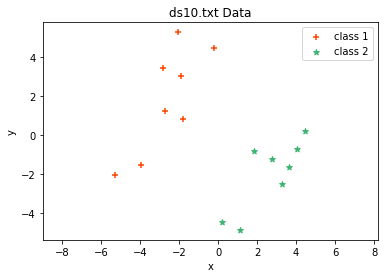

In [14]:
scatter_plot(X, 'ds10.txt Data', 'x', 'y')

We can observe that the data is linearly separable.  

### **Problem 1**. SVC with Karush-Kuhn-Tucker conditions and Wolfe dual representation

The SVM algorithm in matrix notation is:

$HA + \mu Y - \Delta =$ **1**

$ A = \left[ \begin{array}{cc} \lambda_1 \\ \lambda_2 \\ \vdots \\ \lambda_N \end{array} \right],  \mbox{    }
Y = \left[ \begin{array}{cc|r} y_1 \\ y_2 \\ \vdots \\ y_N \end{array} \right], \mbox{    }
\Delta = \left[ \begin{array}{cc|r} \delta_1 \\ \delta_2 \\ \vdots \\ \delta_N \end{array} \right], \mbox{    }
1 = \left[ \begin{array}{cc|r} 1 \\ 1 \\ \vdots \\ 1 \end{array} \right]
$

$ H = \left[ \begin{array}{ccccc}
y_1y_1x_1^Tx_1 & y_1y_2x_1^Tx_2 & \dots & y_1y_Nx_1^Tx_N \\
y_2y_1x_2^Tx_1 & y_2y_2x_2^Tx_2 & \dots & y_2y_Nx_2^Tx_N \\
\vdots & \vdots & \ddots & \vdots \\ 
y_Ny_1x_N^Tx_1 & y_Ny_2x_N^Tx_2 & \dots & y_Ny_Nx_N^Tx_N
\end{array} \right]$

In order to compute support vectors, we need to calculate the $\lambda_i$ corresponding to each $X_i$. If $\lambda_i = 1$, it means that the corresponding $X_i$ is a support vector. 

First, we define the components:

In [15]:
N = y.shape[0] # total points in the data
y_reshape = y.reshape((N,))
P = build_H(X,y_reshape) # the H component
q = -np.ones((N,))
G = -np.identity(N)
h = np.zeros((N,)) 
A = y.reshape((1, -1)) # the Y component
b = np.zeros(1) # the 1 component

Now, we apply the quadratic solver and obtain the $A$ component, which contains the $\lambda_i$.

In [16]:
lm = solve_qp(P, q, G, h, A, b, solver = 'cvxopt') # compute the lambdas 
print(f"Lambdas values for each X component:\n\n {lm}")

Lambdas values for each X component:

 [2.22809816e-10 1.24978656e-01 2.13404255e-05 2.22705596e-10
 4.45512093e-10 4.45411162e-10 2.22730403e-10 4.45675824e-10
 2.70393624e-05 1.24972958e-01 4.45317014e-10 2.22743124e-10
 2.22756052e-10 2.22769186e-10 4.45512093e-10 2.22782525e-10]


Now, the lambdas need to be transformed so the values are either 0 or 1. The $\lambda_i = 1$ means that the corresponding $X_i$ is a *support vector*.

In [17]:
lm_aux = lm > 0.001 # threshold
lambdas = lm_aux.astype(int)
print(f"Support vectors: \n\n{X[np.where(lambdas==1)]}")

Support vectors: 

[[-1.82914321  0.80884801]
 [ 1.82914321 -0.80884801]]


Next, $w$ and $w0$ are computed.

In [18]:
w, w0 = get_w_w0(X, y, np.where(lambdas==1)[0], lm)
w

array([ 0.4571973 , -0.20217287])

In [19]:
w0

array([0.])

The decision function that separates the two classes in the dataset is:

$g(x) = 0.4571x_1 - 0.2021x_2 + 0 = 0.4572x_1 - 0.2021x_2$

Finally, we plot the data points, the support vectors and the decision function.

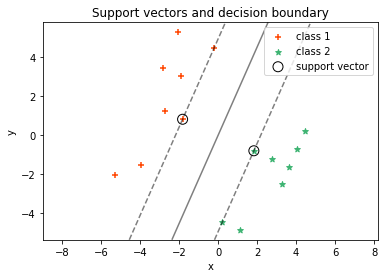

In [20]:
scatter_plot(X, "Support vectors and decision boundary", "x", "y", w1=w[0], w2=w[1], w0=w0, hil=np.where(lambdas==1))

Also the classification map. 

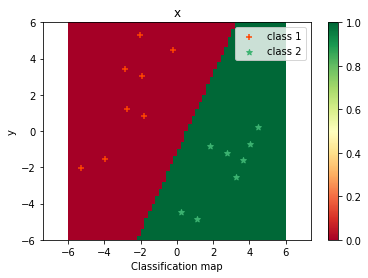

In [21]:
decision_map(X, w[0], w[1], w0, 'Classification map', 'y', 'x')

## sklearn approach: SVC

We have manually implemented all the necessary functions for the SVM algorithm. However, the `scikit` library gathers all these functions plus many more settings for the classifier. Let's use it and compare to the results we have obtained.

In [22]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E16) # We use the linear kernel
model.fit(X, y.reshape((N,)))

SVC(C=1e+16, kernel='linear')

Next, let's plot the decision boundary and the support vectors:

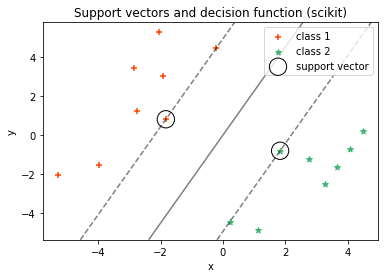

In [23]:
# Plot the points for each class
plt.scatter(X[np.where(y < 0)[0]][:,0], X[np.where(y < 0)[0]][:,1], marker='+', color= '#FF4500', label='class 1')
plt.scatter(X[np.where(y > 0)[0]][:,0], X[np.where(y > 0)[0]][:,1], marker='*', color= '#3CB371', label='class 2')
plt.legend()
plt.title("Support vectors and decision function (scikit)")
plt.xlabel("x")
plt.ylabel("y")
# Plot the decision boundary and support vectors obtained
plot_svc_decision_function(model)

Let's see the values of the support vectors that we have computed with the `scikit` library:

In [22]:
model.support_vectors_

array([[-1.82914321,  0.80884801],
       [ 1.82914321, -0.80884801]])

We can see that the support vectors are the same as obtained with the manual implementation.

Next, let's see the weights $w1, w2$ and $w0$:

In [24]:
model.coef_[0]

array([ 0.4572858, -0.202212 ])

In [25]:
model.intercept_

array([-0.])

The results are almost identical.

Lastly, let's plot the decision map:

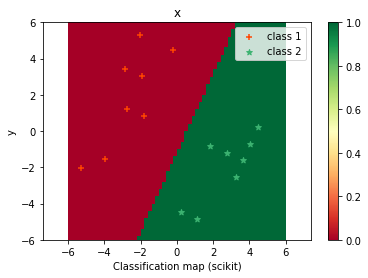

In [36]:
decision_map(X, model.coef_[0][0],model.coef_[0][1], model.intercept_, 'Classification map (scikit)', 'y', 'x')

# Comparison of the manual model and the scikit SVM model

Now, let's compare the results obtained by both models used. We will create a datafrae to visualize the results. 

In [26]:
import pandas as pd

data = {'KKT-W':  [w[0], w[1], w0[0], X[np.where(lambdas==1)]],
        'Scikit SVM': [model.coef_[0][0], model.coef_[0][1], model.intercept_[0], model.support_vectors_]
        }

df = pd.DataFrame (data, columns = ['KKT-W','Scikit SVM'], index=['w1', 'w2', 'w0', 'Support Vectors'])
df.style

,KKT-W,Scikit SVM
w1,0.457197,0.457286
w2,-0.202173,-0.202212
w0,0.000000,-0.000000
Support Vectors,[[-1.82914321 0.80884801] [ 1.82914321 -0.80884801]],[[-1.82914321 0.80884801] [ 1.82914321 -0.80884801]]


We can see that we have obtained almost identical results with both the functions created and the scikit library model. The support vectors are the same, and the plots in both cases is identical. 

# Conclusions

Implementing the algorithm manually is not a trivial matter. We have seen that by using the already defined functions of the `scikit` library we obtained the same results, but much faster. Therefore, by using the libraries provided we can ensure accuracy, a faster implementation and, most importanty, good results, so it is not neccesary to implement any computations manually by creating our own functions. However, it is important to know what's going on "under the hood" of the library's functions, so we should understand how each value is obtained. In conclusion, we should understand the algorithm and how it works, but implementation-wise it is better to use libraries like `scikit`to speed up the process and avoid man-made errors in the algorithms. 